In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from config import get_cfg
from op import Operation

cfg = get_cfg()

operation = Operation(cfg)

In [ ]:
operation.load(path='./exp/D-Mid2-Encoder-brains18=0410-013241/model.pt', model_type='Mid2-Encoder')

[  48/  48] 100% |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| -
non_tumor_ent_per_px: 0.009217036121134356
non_tumor_var_per_px: 0.0002220496595284955
tumor_ent_per_px: 0.10609411648417529
tumor_var_per_px: 0.004645804282788648
ents: [0.00291176 0.04150864 0.08664966 0.02809321 0.09279682 0.04101926
 0.03355343 0.03183463 0.04351317 0.10609412]
vars: [6.63201556e-05 7.52400756e-04 2.51944244e-03 5.15008235e-04
 2.46974460e-03 1.38680874e-03 6.19223680e-04 8.26362113e-04
 1.11118505e-03 4.64580428e-03]
dices: [0.995, 0.860, 0.888, 0.854, 0.689, 0.816, 0.959, 0.947, 0.954, 0.000] [0.871]


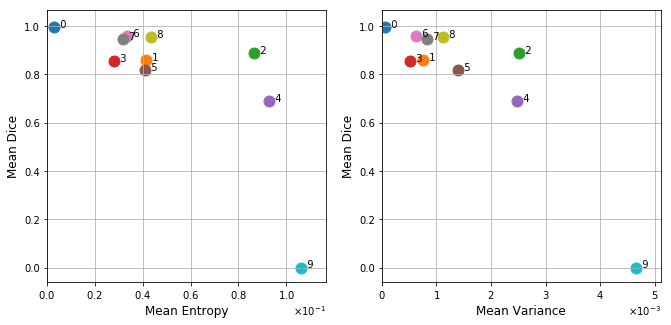

In [26]:
operation.analyse_ent_var_dice_and_draw_scatter_tumor(mode='Dropout')

[  48/  48] 100% |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| -
non_tumor_ent_per_px: 0.013234314720235854
non_tumor_var_per_px: 0.001368088564671644
tumor_ent_per_px: 0.16150279401270973
tumor_var_per_px: 0.022207578766671576
ents: [0.00425254 0.05253458 0.12712276 0.04337304 0.12477997 0.05606886
 0.08288796 0.05562906 0.08612832 0.16150279]
vars: [0.00030356 0.00529112 0.01307439 0.003787   0.01130319 0.00905947
 0.00638703 0.00496756 0.0061875  0.02220758]
dices: [0.994, 0.835, 0.899, 0.876, 0.676, 0.796, 0.897, 0.931, 0.932, 0.000] [0.855]


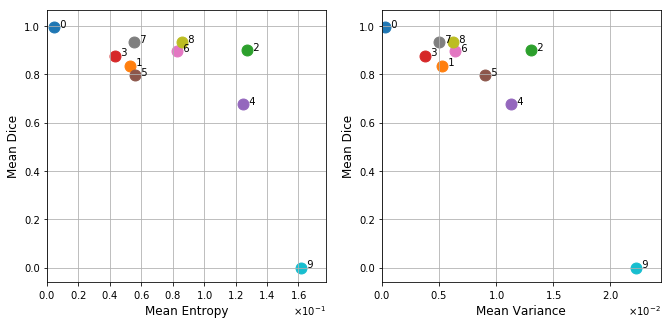

In [25]:
operation.analyse_ent_var_dice_and_draw_scatter_tumor(mode='Ensemble')

In [27]:
operation.load_val_data(is_tumor=False)

Ensemble
0
6
12
18
24
30
36
42
0 entropy min max: 0.0015786776 0.20516236
0 variance min max: 5.209786e-08 0.0417222
1 entropy min max: 0.0015669181 0.16831252
1 variance min max: 5.235222e-08 0.03947824
2 entropy min max: 0.0012219925 0.19596905
2 variance min max: 4.769949e-08 0.043524045
3 entropy min max: 0.00094565295 0.21029688
3 variance min max: 2.4597114e-08 0.037908655
4 entropy min max: 0.0011201965 0.1961569
4 variance min max: 4.3253454e-08 0.03411789
5 entropy min max: 0.0009812244 0.16210204
5 variance min max: 5.471191e-08 0.035076823
6 entropy min max: 0.0012310448 0.14255962
6 variance min max: 3.9469203e-08 0.04034757
7 entropy min max: 0.0016016838 0.17938308
7 variance min max: 5.1125806e-08 0.042769734


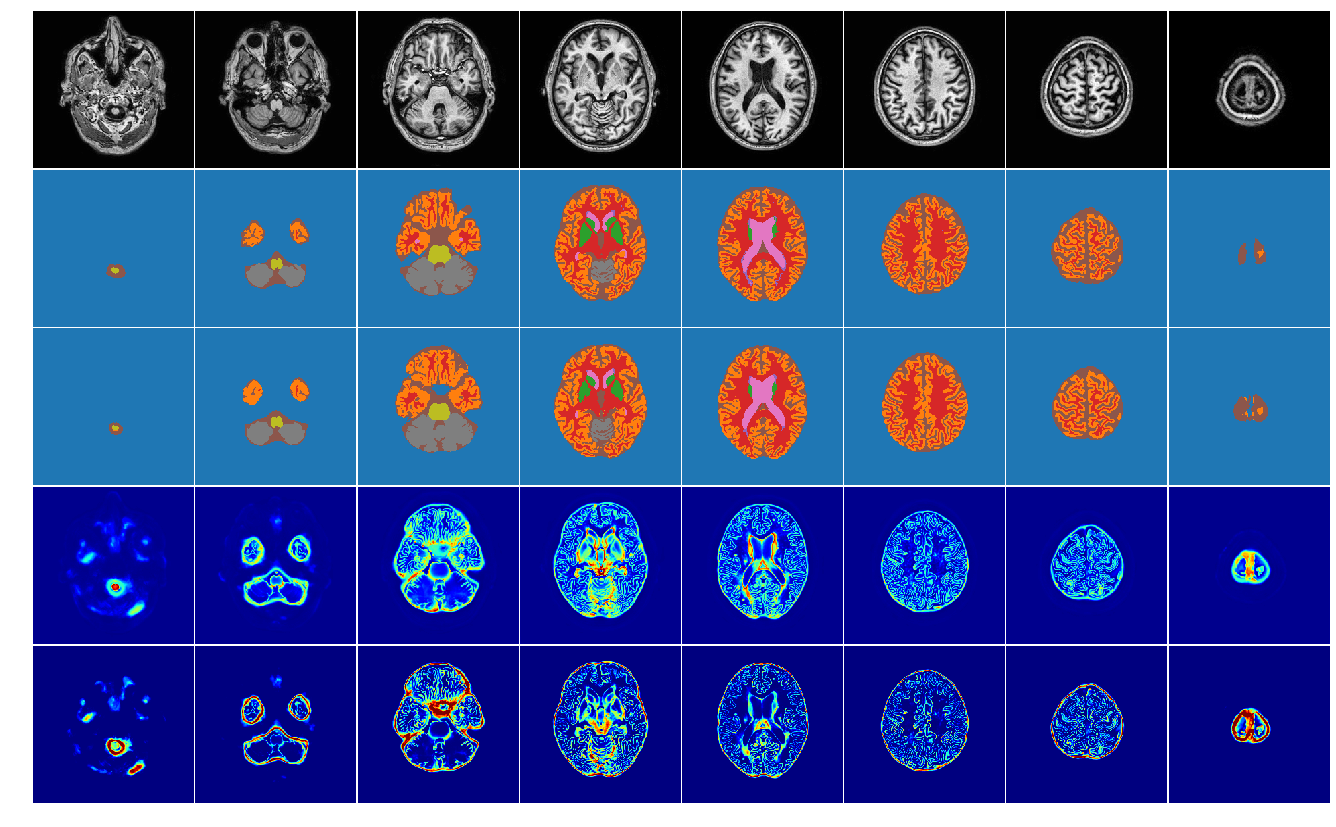

In [28]:
operation.get_picture_many(mode='Ensemble')

Dropout
0
6
12
18
24
30
36
42
0 entropy min max: 0.00041906754 0.18457823
0 variance min max: 2.3225565e-10 0.022334987
1 entropy min max: 0.00054136035 0.16676074
1 variance min max: 2.8770022e-10 0.019921253
2 entropy min max: 0.00040344708 0.1942851
2 variance min max: 2.5194968e-10 0.01799447
3 entropy min max: 0.0006159977 0.19583233
3 variance min max: 2.4273103e-10 0.021623764
4 entropy min max: 0.00040074575 0.18343866
4 variance min max: 2.6956207e-10 0.013927041
5 entropy min max: 0.00034737715 0.13950746
5 variance min max: 3.2270608e-10 0.015855808
6 entropy min max: 0.00037425614 0.124180526
6 variance min max: 2.777264e-10 0.015097224
7 entropy min max: 0.00050115836 0.15736005
7 variance min max: 1.7789792e-10 0.020388957


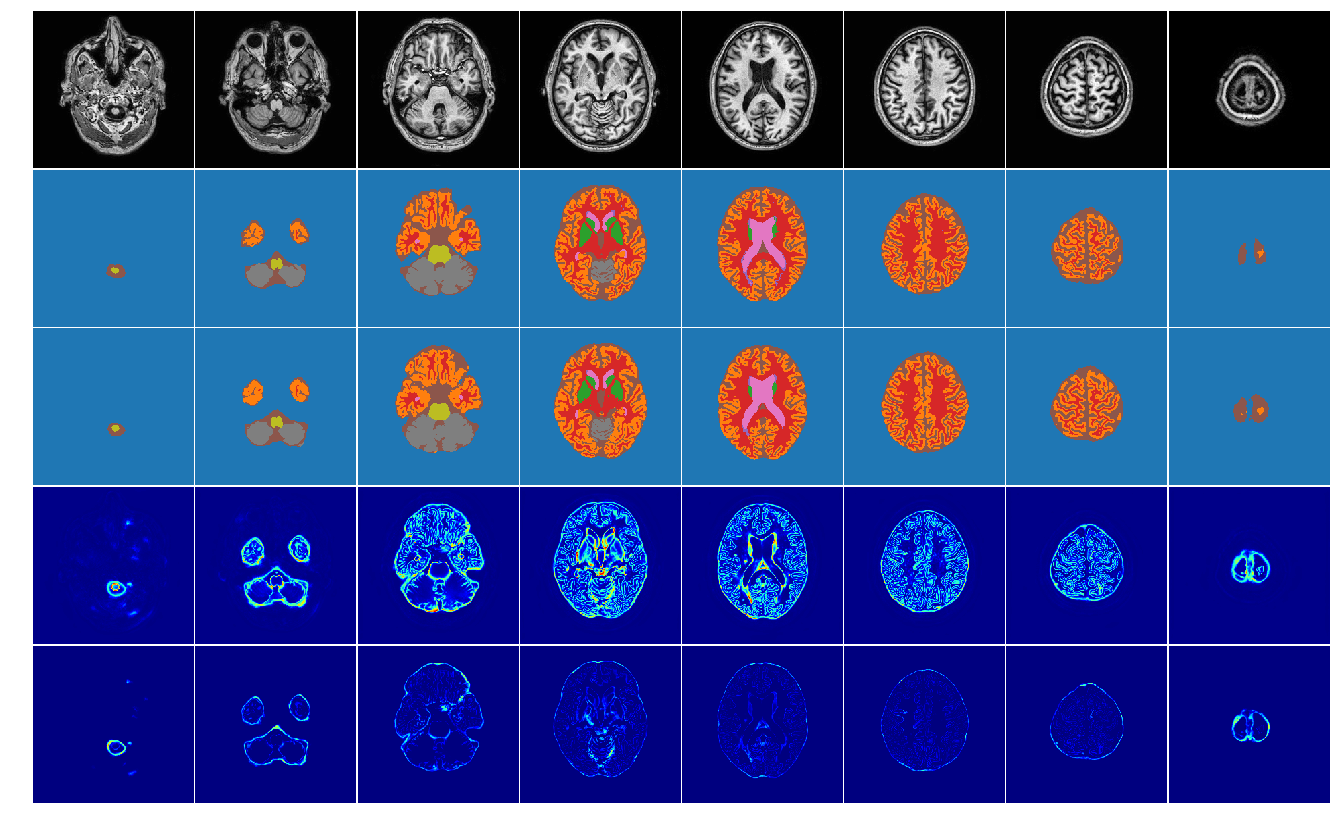

In [29]:
operation.get_picture_many(mode='Dropout')

[  48/  48] 100% |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| -
dices: [0.995, 0.847, 0.922, 0.881, 0.692, 0.803, 0.898, 0.947, 0.933] [0.865]


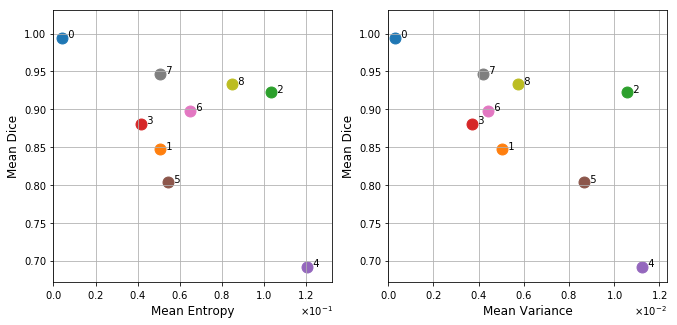

In [30]:
operation.analyse_ent_var_dice_and_draw_scatter(mode='Ensemble')

[  48/  48] 100% |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| -
dices: [0.995, 0.871, 0.927, 0.859, 0.708, 0.823, 0.969, 0.958, 0.956] [0.884]


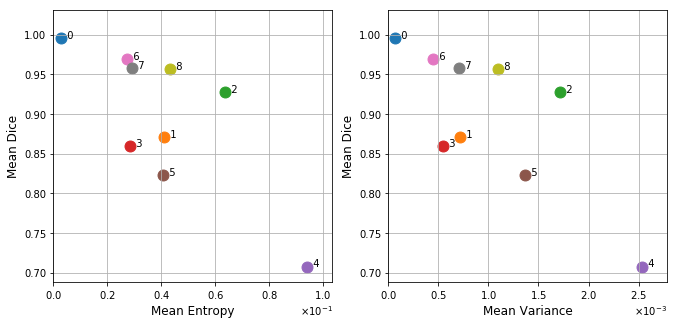

In [31]:
operation.analyse_ent_var_dice_and_draw_scatter(mode='Dropout')

In [ ]:
def show_result(data, ids):
    for i in ids:
        imgs, folder, slice_id = data[i]
        operation.predict(imgs[2], imgs[3], mode='Dropout', title='{} {}'.format(folder, slice_id))

show_result(operation.val_data, [26])